In [1]:
import sys
from heapq import heappush, heappop
from random import expovariate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [36]:
# Shortcut constants
KB = 1024  # bytes
MB = 1024 ** 2  # bytes
GB = 1024 ** 3  # bytes
MINUTE = 60
HOUR = 60 * 60  # seconds
DAY = 24 * HOUR  # seconds
YEAR = 365 * DAY
### SYSTEM PARAMETERS
N = 10  # number of servers storing data
K = [1,2,3,4,5,6,7,8,9,10] #[4,7,9]  # number of blocks needed to recover data
# parameters about the node backing up the data
# parameters about the node backing up the data
NODE_LIFETIME = 30 * DAY  # average time before node crashes and loses data
NODE_UPTIME = 8 * HOUR  # average time spent online by the node
NODE_DOWNTIME = 16 * HOUR  # average time spent offline
DATA_SIZE = [5*GB, 50*GB, 500*GB]  # amount of data to backup 100*GB,250*GB
UPLOAD_SPEED = [ 500 * KB, 5*MB]  # node's speed, per second
DOWNLOAD_SPEED = [ 2 * MB, 8* MB ] # per second

# parameters as before, for the server
SERVER_LIFETIME = 1 * YEAR
SERVER_UPTIME = 30 * DAY
SERVER_DOWNTIME = 2 * HOUR

# length of the simulation
MAXT = 10 * YEAR

In [37]:
def log(state, message):
    print(f'[{state.t / YEAR:5.2f} {sum(state.local_blocks):2} '
          f'{sum(state.remote_blocks):2}] {message}', file=sys.stderr)


def exp_rv(mean):
    """Return an exponential random variable with the given mean."""
    return expovariate(1 / mean)

In [38]:
k_val = 0

class GameOver(Exception):
    """Not enough redundancy in the system, data is lost."""
    pass

class State:
    def __init__(self):
        self.t = t = 0  # seconds
        self.node_online = True  # the node starts online
        self.server_online = [True] * N  # servers all start online
        self.remote_blocks = [[False] * N ] * N  # no server starts having their block
        self.local_blocks = [True] * N  # flags each locally owned block

        self.current_upload = self.current_download = None
        self.events = []  # event queue

        self.schedule(exp_rv(NODE_UPTIME), NodeOffline())
        self.schedule(exp_rv(NODE_LIFETIME), NodeFail())
        for i in range(N):
            self.schedule(exp_rv(SERVER_UPTIME), ServerOffline(i))
            self.schedule(exp_rv(SERVER_LIFETIME), ServerFail(i))
        self.schedule_next_upload()
        self.failure_counter = 0

    def schedule(self, delay, event):
        """Add an event to the event queue after the required delay."""
        heappush(self.events, (self.t + delay, event))

    def schedule_next_upload(self):
        """Schedule the next upload, if any."""
        if self.node_online:
              for i in range(0,N):
                 for j in range(0,N):
                        if self.local_blocks[i] and self.server_online[i] and not self.remote_blocks[i][j]:
                            self.current_upload = UploadComplete(i,j)
                            self.schedule(exp_rv(upload_duration), self.current_upload)

    def schedule_next_download(self):
        if self.node_online:
            for i in range(0,N):
                 for j in range(0,N):
                        if self.remote_blocks[i][j] and self.server_online[i] and not self.local_blocks[i]:
                            self.current_download = DownloadComplete(i)
                            self.schedule(exp_rv(download_duration), self.current_download)
        # if the node is online, download a remote block the node doesn't
        # have from an online server which has it (if possible)
        # raise NotImplementedException

    def check_game_over(self):
        self.failure_counter += 1
        lbs, rbs = state.local_blocks, state.remote_blocks
        result = []
        for i in rbs:
            result.append(any(i))
        blocks_saved = [lb or rb for lb, rb in zip(lbs, result)]
        if sum(blocks_saved) < k_val:
            raise GameOver

# events
class ServerEvent:
    """Class with a self.server attribute."""

    def __init__(self, server):
        self.server = server

    def __str__(self):  # function to get a pretty printed name for the event
        return f'{self.__class__.__name__}({self.server})'


class UploadComplete(ServerEvent):
    """An upload is completed."""
    def __init__(self, server, block):
        super().__init__(server)
        self.block = block

    def process(self, state):
        if state.current_upload is not self:
            # this upload was interrupted, we ignore this event
            return
        state.remote_blocks[self.server][self.block] = True
        state.schedule_next_upload()


class DownloadComplete(ServerEvent):
    """A download is completed."""

    def process(self, state):
        if state.current_download is not self:
            # download interrupted
            return
        lb = state.local_blocks
        lb[self.server] = True
        if sum(lb) >= k_val:  # we have enough data to reconstruct all blocks
            state.local_blocks = [True] * N
        else:
            state.schedule_next_download()


class NodeOnline:
    """Our node went online."""

    def process(self, state):
        state.node_online = True
        state.schedule_next_upload()
        state.schedule_next_download()
        state.schedule(exp_rv(NODE_UPTIME), NodeOffline())


class NodeOffline:
    """Our node went offline."""

    def process(self, state):
        # mark the node as offline
        state.node_online = False
        # cancel current upload and download
        state.current_upload = state.current_download = None
        # schedule the next online event
        state.schedule(exp_rv(NODE_DOWNTIME), NodeOnline())


class NodeFail(NodeOffline):
    """Our node failed and lost all its data."""

    def process(self, state):
        # mark all local blocks as lost
        state.local_blocks = [False] * N
        state.check_game_over()
        state.schedule(exp_rv(NODE_LIFETIME), NodeFail())
        super().process(state)


class ServerOnline(ServerEvent):
    """A server that was offline went back online."""

    def process(self, state):
        server = self.server
        state.server_online[server] = True
        state.schedule(exp_rv(SERVER_UPTIME), ServerOffline(server))
        cu = state.current_upload
        cd = state.current_download
        if cu is not None:
            state.schedule_next_upload()
        if cd is not None:
            state.schedule_next_download()


class ServerOffline(ServerEvent):
    """A server went offline."""

    def process(self, state):
        server = self.server
        # mark the server as offline
        state.server_online[server] = False
        # schedule the next server online event
        state.schedule(exp_rv(SERVER_DOWNTIME), ServerOnline(server))
        # interrupt any current uploads/downloads to this server
        cu = state.current_upload
        if cu is not None and cu.server == server:
            state.current_upload = None
        cd = state.current_download
        if cd is not None and cd.server == server:
            state.current_download = None


class ServerFail(ServerOffline):
    """A server failed and lost its data."""

    def process(self, state):
        state.remote_blocks[self.server] = [False] * N
        state.check_game_over()
        state.schedule(exp_rv(SERVER_LIFETIME), ServerFail(self.server))
        super().process(state)

In [39]:
def failurePlot(fail_for_speed):
    width = 0.35 
    fig, ax = plt.subplots()
    for x,y in failure_per_k.items():
        rects1 = ax.bar(x-0.2 , y[0], width, color = 'red')
        rects2 = ax.bar(x, y[1], width,color = 'lightblue' )
        rects2 = ax.bar(x+0.2 , y[2], width, color = 'green')
    ax.set_xticks(list(failure_per_k.keys()))
    ax.set_yticks(list(range(0, 6)))
    ax.set_xlabel('K Value')
    ax.set_ylabel('No. of Game Overs')
    ax.set_title('Gameover with varying upload/download speeds')
    ax.legend(['50KB & 300KB', '500 KB & 2MB','5MB & 8MB'])
    fig.tight_layout()
    plt.show()

def plot_blocks(res_per_data):
    print('inside')
    for i in range(0,len(DATA_SIZE)):
        plt.plot(K, list(res_per_data.values())[i])
        print(list(res_per_data.keys())[i])
    plt.legend([str(x / GB) +" GB"  for x in DATA_SIZE], loc='upper right')
    plt.xticks(K)
    plt.yticks(list(range(0, 11)))
    plt.xlabel('K Val', fontsize=16)
    plt.ylabel('Average Years', fontsize=16)
    plt.show()
    

In [ ]:
# simulation for failure rate for different upload and download speeds
failure_per_k={}
for data_val in DATA_SIZE:
    print("Data Size in GB", data_val/GB)
    for k_val in K:
            complete_failure = []
            for upload_speed, download_speed in zip(UPLOAD_SPEED, DOWNLOAD_SPEED):
                        counter = 0
                        for i in range(0,5): 
                            block_size = data_val / k_val
                            upload_duration = block_size / upload_speed
                            download_duration = block_size / download_speed
                            try:
                                state = State()
                                events = state.events
                                while events:
                                    t, event = heappop(events)
                                    if t > MAXT:
                                        break
                                    state.t = t
                                    event.process(state)
                            except GameOver:
                                counter = counter + 1
                        complete_failure.append(counter)
                        failure_per_k[k_val] = complete_failure
    failurePlot(failure_per_k)

0.48828125 2.0
Game over after 3.77 years! 10 0.48828125 2.0 5368709120
Game over after 3.17 years! 10 0.48828125 2.0 5368709120
Game over after 1.88 years! 10 0.48828125 2.0 5368709120
Game over after 0.01 years! 2 0.48828125 2.0 53687091200
Game over after 0.00 years! 5 0.48828125 2.0 53687091200
Game over after 0.94 years! 10 0.48828125 2.0 53687091200
Game over after 1.51 years! 10 0.48828125 2.0 53687091200
Game over after 0.78 years! 10 0.48828125 2.0 53687091200
Game over after 3.52 years! 10 0.48828125 2.0 53687091200
Game over after 2.95 years! 10 0.48828125 2.0 53687091200
Game over after 6.38 years! 10 0.48828125 2.0 53687091200
Game over after 0.11 years! 1 0.48828125 2.0 536870912000
Game over after 6.35 years! 1 0.48828125 2.0 536870912000
Game over after 0.02 years! 1 0.48828125 2.0 536870912000
Game over after 7.84 years! 1 0.48828125 2.0 536870912000
Game over after 9.12 years! 1 0.48828125 2.0 536870912000
Game over after 3.55 years! 2 0.48828125 2.0 536870912000
Game

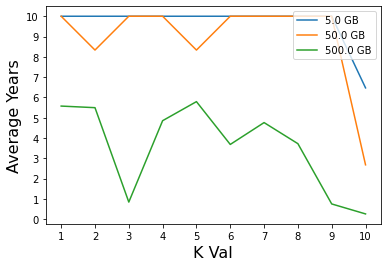

5.0 8.0
Game over after 8.04 years! 10 5.0 8.0 5368709120
Game over after 3.22 years! 10 5.0 8.0 5368709120
Game over after 0.45 years! 10 5.0 8.0 5368709120
Game over after 2.26 years! 10 5.0 8.0 53687091200
Game over after 4.15 years! 10 5.0 8.0 53687091200
Game over after 3.54 years! 10 5.0 8.0 53687091200
Game over after 4.56 years! 10 5.0 8.0 53687091200
Game over after 0.02 years! 1 5.0 8.0 536870912000
Game over after 0.00 years! 6 5.0 8.0 536870912000
Game over after 0.00 years! 9 5.0 8.0 536870912000
Game over after 1.66 years! 10 5.0 8.0 536870912000
Game over after 0.14 years! 10 5.0 8.0 536870912000
Game over after 4.90 years! 10 5.0 8.0 536870912000
Game over after 3.49 years! 10 5.0 8.0 536870912000
Game over after 0.07 years! 10 5.0 8.0 536870912000
Game over after 0.98 years! 10 5.0 8.0 536870912000
{5.0: [9.999984694778759, 9.999994211508723, 9.99999228655914, 9.999992196562703, 9.999988393248387, 9.999991589032879, 9.999975689996507, 9.999996286606967, 9.9999962904950

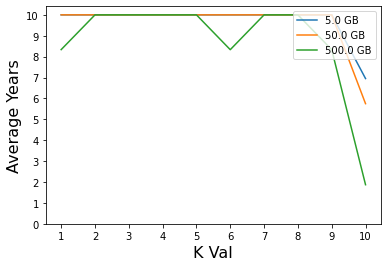

In [40]:
# simulation for life time with different upload and download speeds
res_per_data = {}
for upload_speed, download_speed in zip(UPLOAD_SPEED, DOWNLOAD_SPEED):
    print(upload_speed/MB, download_speed/MB)
    for data_val in DATA_SIZE:
        res_per_k = []
        for k_val in K:
                    block_size = data_val / k_val
                    upload_duration = block_size / upload_speed
                    download_duration = block_size / download_speed
                    time_arr = []
                    for i in range(11):
                        try:
                                state = State()
                                events = state.events
                                while events:
                                    t, event = heappop(events)
                                    if t > MAXT:
                                        break
                                    state.t = t
                                    event.process(state)
                        except GameOver:
                            print(f"Game over after {t / YEAR:.2f} years!", k_val, upload_speed/MB, download_speed/MB, data_val)                                                                
                        finally:
                            time_arr.append(state.t/YEAR)
                    res_per_k.append(sum(time_arr)/len(time_arr))
        res_per_data[data_val/GB] = res_per_k
    print(res_per_data)
    plot_blocks(res_per_data)